# 1 Image

C:\Users\rensl\AppData\Local\Temp\ipykernel_17260\2238935904.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CPU)


Keypoints:
 [[244. 254. 117. ... 388.  20. 397.]
 [ 10.  18.  19. ... 454. 458. 461.]]
Descriptors:
 [[-0.03540225  0.04491057  0.00481831 ...  0.01979008 -0.09370545
   0.09748257]
 [-0.12320253  0.1053544  -0.05543514 ...  0.01660676 -0.14043096
   0.10752165]
 [-0.1111327   0.1336931  -0.04150601 ...  0.1021921  -0.14162777
   0.0545682 ]
 ...
 [-0.11491863  0.03237356 -0.03974679 ...  0.16076459  0.02068276
   0.1115811 ]
 [-0.14201078 -0.0193711  -0.09208278 ...  0.06631798 -0.07859424
   0.09573212]
 [ 0.00464636  0.02905069 -0.01898005 ...  0.10854592 -0.0110418
   0.11708248]]
Scores:
 [3.1561964 2.2122893 2.5396214 ... 1.6373953 0.9179312 2.5375698]
Keypoints shape: (2, 1645)
Scores length: 1645


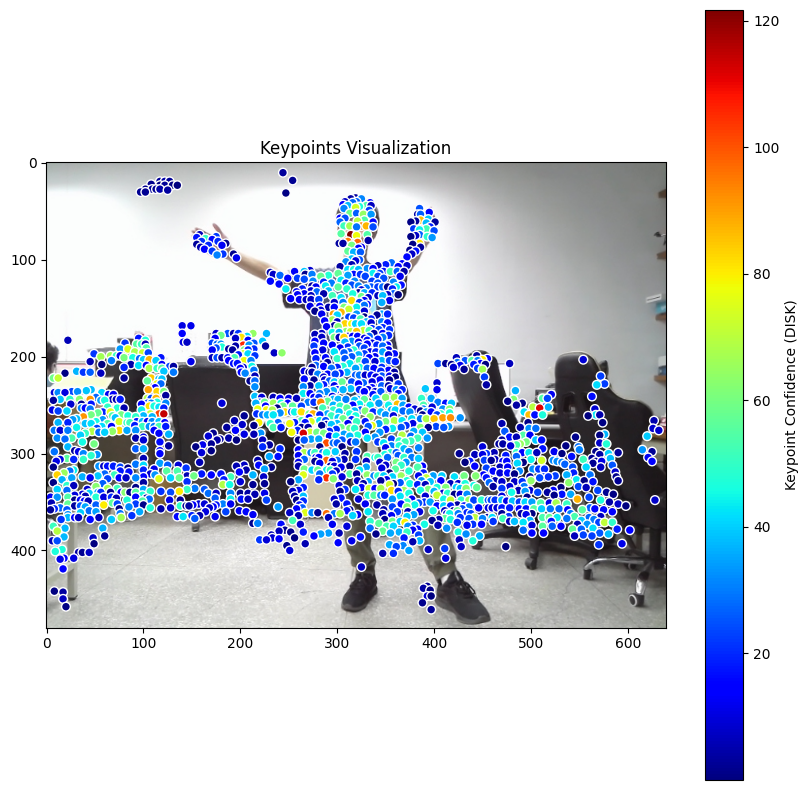

In [1]:
import torch
import imageio
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_dimcheck import dimchecked
import sys

sys.path.append(os.path.abspath('disk'))
from disk import DISK, Features


# Define Image class for handling image resizing, padding, etc.
class Image:
    def __init__(self, bitmap: ['C', 'H', 'W'], fname: str, orig_shape=None):
        self.bitmap = bitmap
        self.fname = fname
        if orig_shape is None:
            self.orig_shape = self.bitmap.shape[1:]
        else:
            self.orig_shape = orig_shape

    def resize_to(self, shape):
        return Image(
            self._pad(self._interpolate(self.bitmap, shape), shape),
            self.fname,
            orig_shape=self.bitmap.shape[1:],
        )

    @dimchecked
    def to_image_coord(self, xys: [2, 'N']) -> ([2, 'N'], ['N']):
        f, _size = self._compute_interpolation_size(self.bitmap.shape[1:])
        scaled = xys / f

        h, w = self.orig_shape
        x, y = scaled

        mask = (0 <= x) & (x < w) & (0 <= y) & (y < h)

        return scaled, mask

    def _compute_interpolation_size(self, shape):
        x_factor = self.orig_shape[0] / shape[0]
        y_factor = self.orig_shape[1] / shape[1]

        f = 1 / max(x_factor, y_factor)

        if x_factor > y_factor:
            new_size = (shape[0], int(f * self.orig_shape[1]))
        else:
            new_size = (int(f * self.orig_shape[0]), shape[1])

        return f, new_size

    @dimchecked
    def _interpolate(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        _f, size = self._compute_interpolation_size(shape)
        return F.interpolate(
            image.unsqueeze(0),
            size=size,
            mode='bilinear',
            align_corners=False,
        ).squeeze(0)

    @dimchecked
    def _pad(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        x_pad = shape[0] - image.shape[1]
        y_pad = shape[1] - image.shape[2]

        if x_pad < 0 or y_pad < 0:
            raise ValueError("Attempting to pad by negative value")

        return F.pad(image, (0, y_pad, 0, x_pad))


# Function to extract features and descriptors from a single image
def extract_single_image(image_path, model):
    img = np.ascontiguousarray(imageio.imread(image_path))
    tensor = torch.from_numpy(img).to(torch.float32)

    if len(tensor.shape) == 2:  # If grayscale image, expand to 3 channels
        tensor = tensor.unsqueeze(-1).expand(-1, -1, 3)

    bitmap = tensor.permute(2, 0, 1) / 255.  # Normalize image
    image = Image(bitmap, os.path.splitext(os.path.basename(image_path))[0])

    bitmap = bitmap.unsqueeze(0)  # Add batch dimension
    bitmap = bitmap.to(DEV, non_blocking=True)

    with torch.no_grad():
        features = model.features(bitmap, kind='nms').flat[0].to(CPU)

    keypoints = features.kp.T
    descriptors = features.desc
    scores = features.kp_logp

    return keypoints.numpy(), descriptors.numpy(), scores.numpy()

# Function to visualize keypoints on a single image
def visualize_keypoints(image_path, keypoints, scores):
    img = imageio.imread(image_path)

    # Print the shapes for debugging
    print(f"Keypoints shape: {keypoints.shape}")
    print(f"Scores length: {len(scores)}")

    # Transpose keypoints to get (N, 2) shape
    keypoints = keypoints.T  # Now shape is (1645, 2)

    # Use the minimum length between keypoints and scores to avoid mismatch
    min_length = min(keypoints.shape[0], len(scores))
    keypoints = keypoints[:min_length]
    scores = scores[:min_length]

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c=scores, cmap='jet', s=40, edgecolors='white')
    plt.colorbar(label='Keypoint Confidence (DISK)')
    plt.title('Keypoints Visualization')
    plt.show()




# Main script to load the model, process a single image, and visualize keypoints
if __name__ == '__main__':
    # Device configuration
    DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    CPU = torch.device('cpu')

    # Load the pre-trained model
    model_path = 'disk/depth-save.pth'
    state_dict = torch.load(model_path, map_location=CPU)

    if 'extractor' in state_dict:
        weights = state_dict['extractor']
    elif 'disk' in state_dict:
        weights = state_dict['disk']
    else:
        raise KeyError('Incompatible weight file!')

    # Initialize DISK model
    model = DISK(window=8, desc_dim=128)
    model.load_state_dict(weights)
    model = model.to(DEV)

    # Path to the input image
    input_image = 'data_bruh/cam1/cam1_20240920_031911_0000.png'

    # Extract keypoints, descriptors, and scores
    keypoints, descriptors, scores = extract_single_image(input_image, model)

    print("Keypoints:\n", keypoints)
    print("Descriptors:\n", descriptors)
    print("Scores:\n", scores)

    # Visualize keypoints on the image
    visualize_keypoints(input_image, keypoints, scores)


# 2 Images

C:\Users\rensl\AppData\Local\Temp\ipykernel_17260\3565390072.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CPU)


Image 1 Keypoints:
[[325. 314. 311. 321. 203.  45. 283. 509. 116. 121.  38. 409. 417. 265.
  289. 289. 289. 289.]
 [ 65.  74.  81.  82. 188. 244. 247. 253. 259. 259. 262. 263. 263. 279.
  289. 307. 325. 362.]]
Image 2 Keypoints:
[[315. 306. 318. 296. 314. 322. 450. 445. 315. 304. 441. 309. 542. 420.
  418. 255.  24. 434. 265. 336. 212.  37. 404. 398. 140. 220. 158. 169.
  296. 236. 245. 157. 168. 234. 244.   7. 156. 167. 243. 233. 244. 429.
   45.]
 [ 87.  93.  96.  97. 102. 104. 125. 132. 158. 169. 170. 193. 211. 219.
  241. 253. 262. 266. 268. 270. 273. 274. 275. 276. 284. 288. 295. 295.
  295. 297. 297. 314. 314. 316. 316. 328. 333. 333. 334. 335. 343. 373.
  374.]]


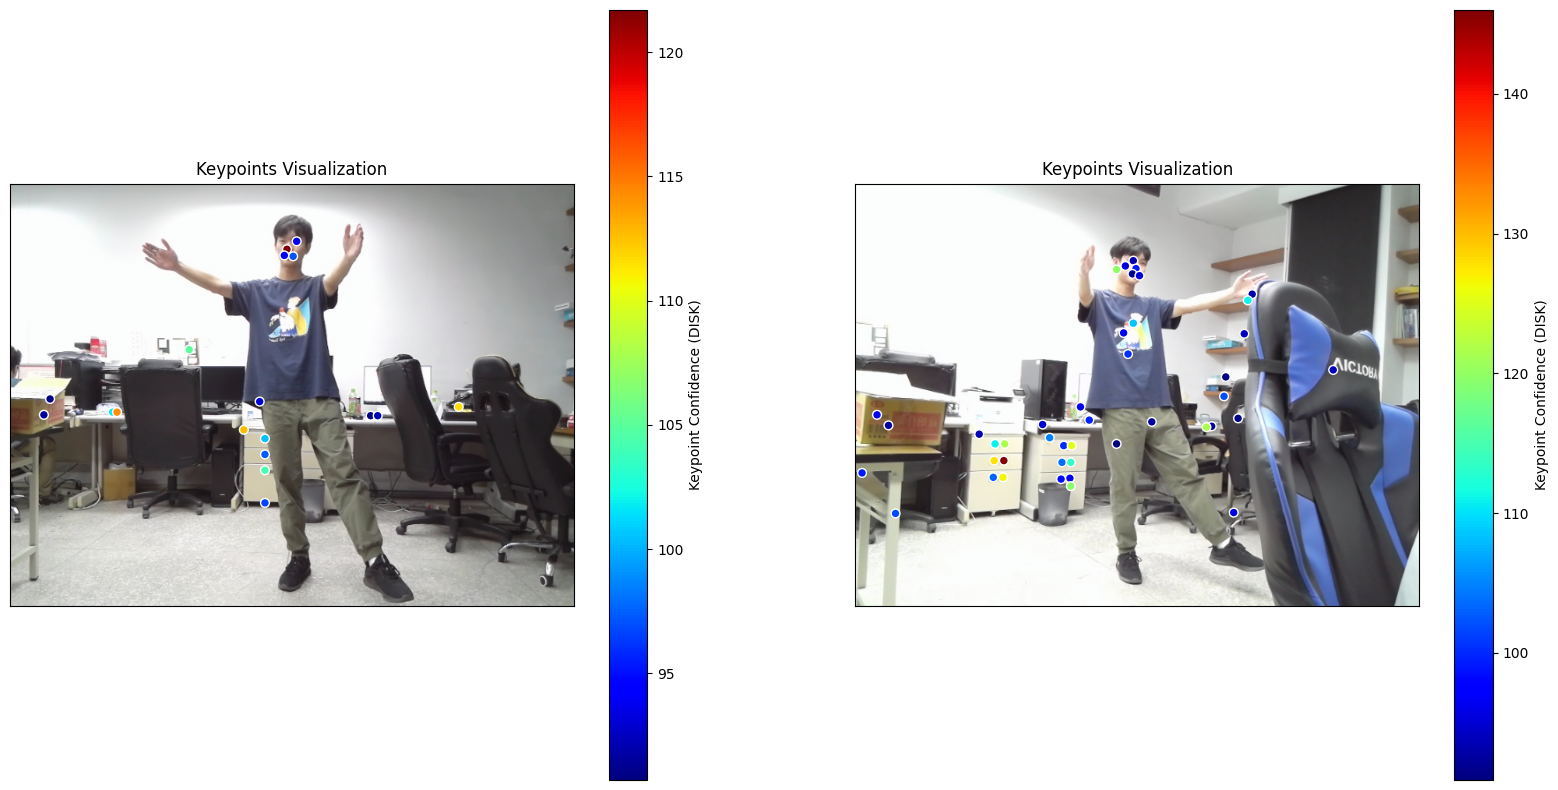

In [18]:
import torch
import imageio
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_dimcheck import dimchecked
import sys

sys.path.append(os.path.abspath('disk'))
from disk import DISK, Features


# Define Image class for handling image resizing, padding, etc.
class Image:
    def __init__(self, bitmap: ['C', 'H', 'W'], fname: str, orig_shape=None):
        self.bitmap = bitmap
        self.fname = fname
        if orig_shape is None:
            self.orig_shape = self.bitmap.shape[1:]
        else:
            self.orig_shape = orig_shape

    def resize_to(self, shape):
        return Image(
            self._pad(self._interpolate(self.bitmap, shape), shape),
            self.fname,
            orig_shape=self.bitmap.shape[1:],
        )

    @dimchecked
    def to_image_coord(self, xys: [2, 'N']) -> ([2, 'N'], ['N']):
        f, _size = self._compute_interpolation_size(self.bitmap.shape[1:])
        scaled = xys / f

        h, w = self.orig_shape
        x, y = scaled

        mask = (0 <= x) & (x < w) & (0 <= y) & (y < h)

        return scaled, mask

    def _compute_interpolation_size(self, shape):
        x_factor = self.orig_shape[0] / shape[0]
        y_factor = self.orig_shape[1] / shape[1]

        f = 1 / max(x_factor, y_factor)

        if x_factor > y_factor:
            new_size = (shape[0], int(f * self.orig_shape[1]))
        else:
            new_size = (int(f * self.orig_shape[0]), shape[1])

        return f, new_size

    @dimchecked
    def _interpolate(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        _f, size = self._compute_interpolation_size(shape)
        return F.interpolate(
            image.unsqueeze(0),
            size=size,
            mode='bilinear',
            align_corners=False,
        ).squeeze(0)

    @dimchecked
    def _pad(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        x_pad = shape[0] - image.shape[1]
        y_pad = shape[1] - image.shape[2]

        if x_pad < 0 or y_pad < 0:
            raise ValueError("Attempting to pad by negative value")

        return F.pad(image, (0, y_pad, 0, x_pad))


# Function to extract features and descriptors from a single image with thresholding
def extract_single_image(image_path, model, threshold=0.0):
    img = np.ascontiguousarray(imageio.imread(image_path))
    tensor = torch.from_numpy(img).to(torch.float32)

    if len(tensor.shape) == 2:  # If grayscale image, expand to 3 channels
        tensor = tensor.unsqueeze(-1).expand(-1, -1, 3)

    bitmap = tensor.permute(2, 0, 1) / 255.  # Normalize image
    image = Image(bitmap, os.path.splitext(os.path.basename(image_path))[0])

    bitmap = bitmap.unsqueeze(0)  # Add batch dimension
    bitmap = bitmap.to(DEV, non_blocking=True)

    with torch.no_grad():
        features = model.features(bitmap, kind='nms').flat[0].to(CPU)

    keypoints = features.kp.T
    descriptors = features.desc
    scores = features.kp_logp

    # Apply threshold to scores
    valid_idx = scores > threshold
    keypoints = keypoints[:, valid_idx]
    descriptors = descriptors[valid_idx, :]
    scores = scores[valid_idx]

    return keypoints.numpy(), descriptors.numpy(), scores.numpy()


# Function to visualize keypoints on a single image with a colorbar
def visualize_keypoints(image_path, keypoints, scores, ax=None):
    img = imageio.imread(image_path)

    # Transpose keypoints to get (N, 2) shape
    keypoints = keypoints.T  # Now shape is (N, 2)

    # Use the minimum length between keypoints and scores to avoid mismatch
    min_length = min(keypoints.shape[0], len(scores))
    keypoints = keypoints[:min_length]
    scores = scores[:min_length]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    img_plot = ax.imshow(img)
    scatter = ax.scatter(keypoints[:, 0], keypoints[:, 1], c=scores, cmap='jet', s=40, edgecolors='white')
    
    # Add colorbar for the keypoint scores
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Keypoint Confidence (DISK)')

    ax.set_title('Keypoints Visualization')
    ax.set_xticks([])
    ax.set_yticks([])


# Main script to process two images and visualize keypoints
if __name__ == '__main__':
    # Device configuration
    DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    CPU = torch.device('cpu')

    # Load the pre-trained model
    model_path = 'disk/depth-save.pth'
    state_dict = torch.load(model_path, map_location=CPU)

    if 'extractor' in state_dict:
        weights = state_dict['extractor']
    elif 'disk' in state_dict:
        weights = state_dict['disk']
    else:
        raise KeyError('Incompatible weight file!')

    # Initialize DISK model
    model = DISK(window=8, desc_dim=128)
    model.load_state_dict(weights)
    model = model.to(DEV)

    # Paths to the input images
    image_1 = 'data_bruh/cam1/cam1_20240920_031911_0000.png'
    image_2 = 'data_bruh/cam2/cam2_20240920_031911_0000.png'

    # Set the threshold for keypoint detection
    threshold = -5.0  # Adjust this value to filter keypoints

    # Extract keypoints, descriptors, and scores for both images
    keypoints_1, descriptors_1, scores_1 = extract_single_image(image_1, model, threshold=90)
    keypoints_2, descriptors_2, scores_2 = extract_single_image(image_2, model, threshold=90)

    print(f"Image 1 Keypoints:\n{keypoints_1}")
    print(f"Image 2 Keypoints:\n{keypoints_2}")

    # Visualize keypoints for both images with colorbars
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    visualize_keypoints(image_1, keypoints_1, scores_1, ax=axes[0])
    visualize_keypoints(image_2, keypoints_2, scores_2, ax=axes[1])
    plt.show()


C:\Users\rensl\AppData\Local\Temp\ipykernel_17260\933140409.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CPU)


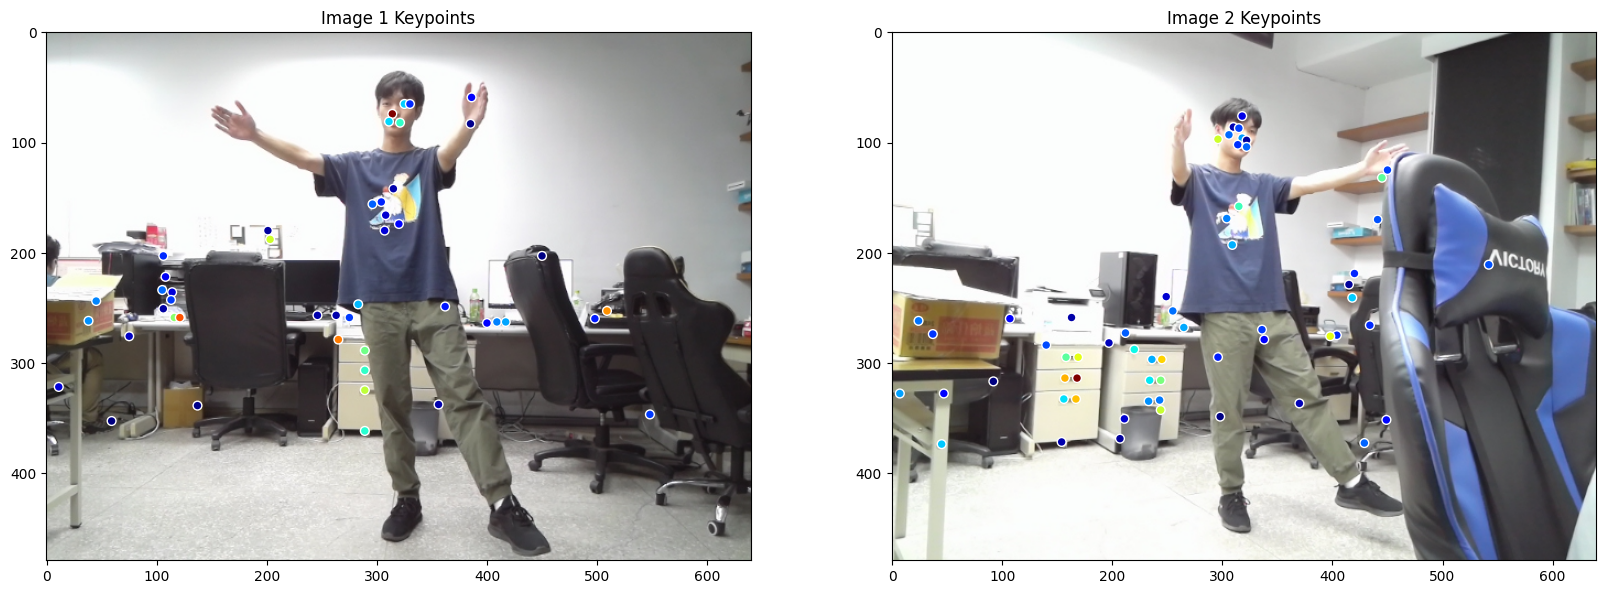

In [55]:
import torch
import imageio
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_dimcheck import dimchecked
import sys

sys.path.append(os.path.abspath('disk'))
from disk import DISK, Features
from disk.geom import distance_matrix


# Define Image class for handling image resizing, padding, etc.
class Image:
    def __init__(self, bitmap: ['C', 'H', 'W'], fname: str, orig_shape=None):
        self.bitmap = bitmap
        self.fname = fname
        if orig_shape is None:
            self.orig_shape = self.bitmap.shape[1:]
        else:
            self.orig_shape = orig_shape

    def resize_to(self, shape):
        return Image(
            self._pad(self._interpolate(self.bitmap, shape), shape),
            self.fname,
            orig_shape=self.bitmap.shape[1:],
        )

    @dimchecked
    def to_image_coord(self, xys: [2, 'N']) -> ([2, 'N'], ['N']):
        f, _size = self._compute_interpolation_size(self.bitmap.shape[1:])
        scaled = xys / f

        h, w = self.orig_shape
        x, y = scaled

        mask = (0 <= x) & (x < w) & (0 <= y) & (y < h)

        return scaled, mask

    def _compute_interpolation_size(self, shape):
        x_factor = self.orig_shape[0] / shape[0]
        y_factor = self.orig_shape[1] / shape[1]

        f = 1 / max(x_factor, y_factor)

        if x_factor > y_factor:
            new_size = (shape[0], int(f * self.orig_shape[1]))
        else:
            new_size = (int(f * self.orig_shape[0]), shape[1])

        return f, new_size

    @dimchecked
    def _interpolate(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        _f, size = self._compute_interpolation_size(shape)
        return F.interpolate(
            image.unsqueeze(0),
            size=size,
            mode='bilinear',
            align_corners=False,
        ).squeeze(0)

    @dimchecked
    def _pad(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        x_pad = shape[0] - image.shape[1]
        y_pad = shape[1] - image.shape[2]

        if x_pad < 0 or y_pad < 0:
            raise ValueError("Attempting to pad by negative value")

        return F.pad(image, (0, y_pad, 0, x_pad))


# Function to extract features and descriptors from a single image with thresholding
def extract_single_image(image_path, model, threshold=0.0):
    img = np.ascontiguousarray(imageio.imread(image_path))
    tensor = torch.from_numpy(img).to(torch.float32)

    if len(tensor.shape) == 2:  # If grayscale image, expand to 3 channels
        tensor = tensor.unsqueeze(-1).expand(-1, -1, 3)

    bitmap = tensor.permute(2, 0, 1) / 255.  # Normalize image
    image = Image(bitmap, os.path.splitext(os.path.basename(image_path))[0])

    bitmap = bitmap.unsqueeze(0)  # Add batch dimension
    bitmap = bitmap.to(DEV, non_blocking=True)

    with torch.no_grad():
        features = model.features(bitmap, kind='nms').flat[0].to(CPU)

    keypoints = features.kp.T
    descriptors = features.desc
    scores = features.kp_logp

    # Apply threshold to scores
    valid_idx = scores > threshold
    keypoints = keypoints[:, valid_idx]
    descriptors = descriptors[valid_idx, :]
    scores = scores[valid_idx]

    return keypoints.numpy(), descriptors.numpy(), scores.numpy()

# Function to visualize keypoints and matches
import imageio
import matplotlib.pyplot as plt
import numpy as np

import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np

def visualize_matches(image_path1, image_path2, kp1, kp2, matches, scores1, scores2, scaling_factor=1):
    img1 = imageio.imread(image_path1)
    img2 = imageio.imread(image_path2)

    # Scale images
    img1 = cv2.resize(img1, (int(img1.shape[1] * scaling_factor), int(img1.shape[0] * scaling_factor)))
    img2 = cv2.resize(img2, (int(img2.shape[1] * scaling_factor), int(img2.shape[0] * scaling_factor)))

    # Scale keypoints accordingly
    kp1_scaled = kp1 * scaling_factor
    kp2_scaled = kp2 * scaling_factor

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(img1)
    ax[0].scatter(kp1_scaled[0, :], kp1_scaled[1, :], c=scores1, cmap='jet', s=40, edgecolors='white')
    ax[0].set_title("Image 1 Keypoints")

    ax[1].imshow(img2)
    ax[1].scatter(kp2_scaled[0, :], kp2_scaled[1, :], c=scores2, cmap='jet', s=40, edgecolors='white')
    ax[1].set_title("Image 2 Keypoints")

    # # Add match lines
    # for m in matches.T:
    #     pt1 = kp1_scaled[:, m[0]]
    #     pt2 = kp2_scaled[:, m[1]] + np.array([img1.shape[1], 0])  # Shift second point to match image2 placement

    #     ax[0].plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='green', lw=1)

    plt.show()

if __name__ == '__main__':
    # Device configuration
    DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    CPU = torch.device('cpu')

    # Load the pre-trained model
    model_path = 'disk/depth-save.pth'
    state_dict = torch.load(model_path, map_location=CPU)

    if 'extractor' in state_dict:
        weights = state_dict['extractor']
    elif 'disk' in state_dict:
        weights = state_dict['disk']
    else:
        raise KeyError('Incompatible weight file!')

    # Initialize DISK model
    model = DISK(window=8, desc_dim=128)
    model.load_state_dict(weights)
    model = model.to(DEV)

    # Paths to the input images
    image_1 = 'data_bruh/cam1/cam1_20240920_031911_0000.png'
    image_2 = 'data_bruh/cam2/cam2_20240920_031911_0000.png'

    # Set the threshold for keypoint detection
    threshold = 80.0

    # Extract keypoints, descriptors, and scores for both images
    keypoints_1, descriptors_1, scores_1 = extract_single_image(image_1, model, threshold)
    keypoints_2, descriptors_2, scores_2 = extract_single_image(image_2, model, threshold)

    # Match descriptors between the two images
    descriptors_1 = torch.from_numpy(descriptors_1)
    descriptors_2 = torch.from_numpy(descriptors_2)

    # Visualize the matches
    visualize_matches(image_1, image_2, keypoints_1, keypoints_2, matches, scores_1, scores_2)


In [51]:
descriptors_1

tensor([[-0.0047,  0.0004,  0.0311,  ...,  0.1464, -0.1142,  0.0713],
        [ 0.0592,  0.0431, -0.1376,  ...,  0.1294, -0.1814,  0.1022],
        [-0.0833,  0.1307, -0.0987,  ...,  0.2419, -0.0815,  0.0653],
        ...,
        [-0.2034, -0.1131, -0.0005,  ...,  0.0781, -0.1073,  0.0803],
        [-0.1021, -0.0367,  0.0030,  ...,  0.0470, -0.0772,  0.1168],
        [ 0.0163,  0.0922, -0.1131,  ...,  0.0751,  0.0199,  0.0333]])

# Imports for Matching

In [54]:
import torch
import numpy as np
from disk.geom import distance_matrix

def match(desc_1, desc_2, rt=1.):
    matched_pairs = _match(desc_1, desc_2, rt)
    matches = matched_pairs.cpu().numpy()
    return matches

def _binary_to_index(binary_mask: torch.Tensor, ix2: torch.Tensor) -> torch.Tensor:
    return torch.stack([
        torch.nonzero(binary_mask)[:, 0],
        ix2
    ], dim=0)

def _ratio_one_way(dist_m: torch.Tensor, rt: float) -> torch.Tensor:
    val, ix = torch.topk(dist_m, k=2, dim=1, largest=False)
    ratio = val[:, 0] / val[:, 1]
    passed_test = ratio < rt
    ix2 = ix[passed_test, 0]
    return _binary_to_index(passed_test, ix2)

def _match_chunkwise(ds1: torch.Tensor, ds2: torch.Tensor, rt: float) -> torch.Tensor:
    MAX_FULL_MATRIX = 10000**2
    chunk_size = MAX_FULL_MATRIX // ds1.shape[0]
    matches = []
    start = 0

    while start < ds2.shape[0]:
        ds2_chunk = ds2[start:start+chunk_size]
        dist_m = distance_matrix(ds1, ds2_chunk)
        one_way = _ratio_one_way(dist_m, rt)
        one_way[1] += start
        matches.append(one_way)
        start += chunk_size

    return torch.cat(matches, dim=1)

def _match(ds1: torch.Tensor, ds2: torch.Tensor, rt: float) -> torch.Tensor:
    fwd = _match_chunkwise(ds1, ds2, rt)
    bck = _match_chunkwise(ds2, ds1, rt)
    bck = torch.flip(bck, (0,))

    merged = torch.cat([fwd, bck], dim=1)
    unique, counts = torch.unique(merged, dim=1, return_counts=True)

    return unique[:, counts == 2]

def match_images(desc_1, desc_2, rt=0.8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    desc_1 = torch.tensor(desc_1, dtype=torch.float32).to(device)
    desc_2 = torch.tensor(desc_2, dtype=torch.float32).to(device)
    
    matches = match(desc_1, desc_2, rt)
    num_matches = matches.shape[1]
    
    # Calculate match scores (you may want to adjust this based on your needs)
    dist_matrix = distance_matrix(desc_1[matches[0]], desc_2[matches[1]])
    match_scores = 1 - dist_matrix.diagonal().cpu().numpy()
    
    return matches, match_scores, num_matches

if __name__ == '__main__':

    matches, scores, num_matches = match_images(descriptors_1, descriptors_2)
    
    print(f"Number of matches: {num_matches}")
    print("Matches shape:", matches.shape)
    print("Match scores:", scores)

Number of matches: 6
Matches shape: (2, 6)
Match scores: [0.24021667 0.27795023 0.4025368  0.34991652 0.34721863 0.25872838]


C:\Users\rensl\AppData\Local\Temp\ipykernel_17260\4062176310.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desc_1 = torch.tensor(desc_1, dtype=torch.float32).to(device)
C:\Users\rensl\AppData\Local\Temp\ipykernel_17260\4062176310.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desc_2 = torch.tensor(desc_2, dtype=torch.float32).to(device)


TRY TRY

In [47]:
print(matches)
    

print(matches[0][0])
print(matches[1][0])

keypoints_1_reshape[matches[0][0]], keypoints_2_reshape[matches[1][0]]

tensor([[ 5,  7,  8, 13, 41, 46],
        [ 8, 11, 12, 14, 47, 57]])
tensor(5)
tensor(8)


(array([321.,  82.], dtype=float32), array([322., 104.], dtype=float32))

In [33]:
keypoints_1_tensor = torch.tensor(keypoints_1)

keypoints_1_tensor

tensor([[386., 325., 330., 314., 311., 321., 385., 315., 304., 296., 308., 320.,
         201., 307., 203., 106., 450., 108., 105., 114., 113.,  45., 283., 362.,
         106., 509., 246., 263., 116., 121., 275., 498.,  38., 409., 417., 400.,
          75., 265., 289., 289.,  11., 289., 356., 137., 548.,  59., 289.],
        [ 59.,  65.,  65.,  74.,  81.,  82.,  83., 142., 154., 156., 166., 174.,
         180., 180., 188., 203., 203., 222., 234., 236., 243., 244., 247., 249.,
         251., 253., 257., 257., 259., 259., 259., 260., 262., 263., 263., 264.,
         276., 279., 289., 307., 322., 325., 338., 339., 347., 353., 362.]])

In [43]:
keypoints_1_reshape = []
keypoints_2_reshape = []

for i, y in enumerate(keypoints_1[1]):
    keypoints_1_reshape.append([keypoints_1[0][i], y])

for i, y in enumerate(keypoints_2[1]):
    keypoints_2_reshape.append([keypoints_2[0][i], y])

keypoints_1_reshape = np.array(keypoints_1_reshape)
keypoints_2_reshape = np.array(keypoints_2_reshape)

print(f"keypoints_1_reshape:\n{keypoints_1_reshape}")
print(f"keypoints_2_reshape:\n{keypoints_2_reshape}")

keypoints_1_reshape:
[[386.  59.]
 [325.  65.]
 [330.  65.]
 [314.  74.]
 [311.  81.]
 [321.  82.]
 [385.  83.]
 [315. 142.]
 [304. 154.]
 [296. 156.]
 [308. 166.]
 [320. 174.]
 [201. 180.]
 [307. 180.]
 [203. 188.]
 [106. 203.]
 [450. 203.]
 [108. 222.]
 [105. 234.]
 [114. 236.]
 [113. 243.]
 [ 45. 244.]
 [283. 247.]
 [362. 249.]
 [106. 251.]
 [509. 253.]
 [246. 257.]
 [263. 257.]
 [116. 259.]
 [121. 259.]
 [275. 259.]
 [498. 260.]
 [ 38. 262.]
 [409. 263.]
 [417. 263.]
 [400. 264.]
 [ 75. 276.]
 [265. 279.]
 [289. 289.]
 [289. 307.]
 [ 11. 322.]
 [289. 325.]
 [356. 338.]
 [137. 339.]
 [548. 347.]
 [ 59. 353.]
 [289. 362.]]
keypoints_2_reshape:
[[318.  76.]
 [310.  86.]
 [315.  87.]
 [306.  93.]
 [318.  96.]
 [296.  97.]
 [322.  98.]
 [314. 102.]
 [322. 104.]
 [450. 125.]
 [445. 132.]
 [315. 158.]
 [304. 169.]
 [441. 170.]
 [309. 193.]
 [542. 211.]
 [420. 219.]
 [415. 229.]
 [249. 240.]
 [418. 241.]
 [255. 253.]
 [163. 259.]
 [107. 260.]
 [ 24. 262.]
 [434. 266.]
 [265. 268.]
 [336. 2

In [46]:
print(matches)
    

print(matches[0][0])
print(matches[1][0])

keypoints_1_reshape[matches[0][0]], keypoints_2_reshape[matches[1][0]]

tensor([[ 5,  7,  8, 13, 41, 46],
        [ 8, 11, 12, 14, 47, 57]])
tensor(5)
tensor(8)


(array([321.,  82.], dtype=float32), array([322., 104.], dtype=float32))